In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real

In [1]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

def cif_alpha_loglink(alphas, xs):
    pre_lam = alphas[None,:,None] + xs
    return np.exp(pre_lam)

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [3]:
fs = 1000
delta = 1/fs

win=1000
L=50
K=2

sample_length = win
em_iters = 20
alpha = 4.0
alpha = float(alpha)
init_type = "flat"
optim_type = "BFGS"

# model_path = f'saved/fitted_models/simple_synthetic_logpoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'
# model_load = pickle_open(model_path)


data_path = f'saved/synthetic_data/simple_synthetic_logpoisson_fixed_gamma_{K}_{L}_{sample_length}'
data_load = pickle_open(data_path)
latent = data_load['latent']
xs = latent['xs']
alphas = np.array([alpha for k in range(K)])
lams = cif_alpha_loglink(alphas, xs)

In [15]:
# C = 1
# alpha=3.5
# init_type='flat'
# optim_type='BFGS'
# seed=8
# em_iters=25
# L=25
# model_path = f'saved/fitted_models/simple_synthetic_{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
# # if link == "relu":
# #     model_path = f'saved/fitted_models/simple_synthetic_deltarelupoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'
# # elif link == 'id':
# # else:
# #     raise ValueError

# model_load = pickle_open(model_path)

Text(0, 0.5, '$\\lambda_t^{k,\\ell}$')

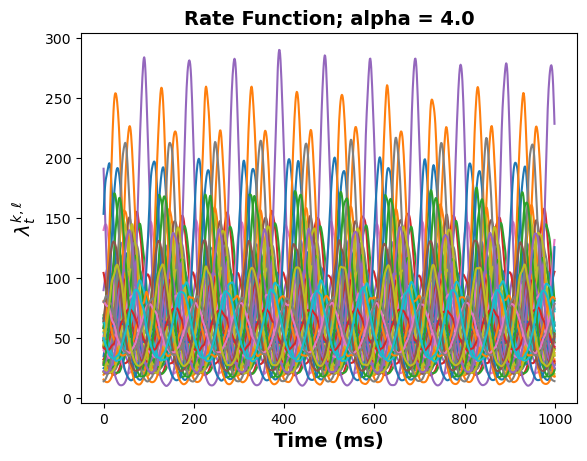

In [4]:
for l in range(L):
    plt.plot(lams[l,0,:])
plt.title(f'Rate Function; alpha = {alpha}', fontweight='bold', fontsize=14)
plt.xlabel('Time (ms)', fontweight='bold', fontsize=14)
plt.ylabel(r'$\lambda_t^{k,\ell}$', fontweight='bold', fontsize=14)

In [3]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
from cohlib.alg.em_sgc import transform_cov_r2c, rearrange_mat
def lognormal_cov(mu, Sigma):
    D = Sigma.shape[0]
    Sigma_ln = np.zeros_like(Sigma)
    for i in range(D):
        for j in range(D):
            sig_ij = np.exp(mu[i] + mu[j] + 0.5*(Sigma[i,i] + Sigma[j,j])) * (np.exp(Sigma[i,j]) - 1)
            Sigma_ln[i,j] = sig_ij

    return Sigma_ln
    
def S_loglink(Gamma, Wv, alpha, alpha0=False):
    delta = 1e-3
    K = Gamma.shape[1]
    num_J_vars = int(2*Gamma.shape[0])
    Wv_inv = np.linalg.pinv(Wv)

    S_lambda = []

    for k in range(K):
        Gamma_k = Gamma[:,k,k][:,None,None]*(delta**2*(2*np.pi)**2)
        Gamma_real = construct_Gamma_full_real(Gamma_k, 1, num_J_vars)
        Sigma_x = Wv @ Gamma_real @ Wv.T

        if alpha0 is True:
            alpha_vec = np.zeros(Sigma_x.shape[0])
        else:
            alpha_vec = np.ones(Sigma_x.shape[0])*alpha
        Sigma_lambda = lognormal_cov(alpha_vec, Sigma_x)

        # Gamma_x_test = Wv_inv @ Sigma_x @ Wv_inv.T 
        # Gamma_control = transform_cov_r2c(rearrange_mat(Gamma_x_test, int(num_J_vars/2)))
        Gamma_lambda_real = Wv_inv @ Sigma_lambda @ Wv_inv.T
        Gamma_lambda = transform_cov_r2c(rearrange_mat(Gamma_lambda_real, int(num_J_vars/2)))
        S_lambda_k = np.diag(np.abs(Gamma_lambda))
        S_lambda.append(S_lambda_k)
    return np.stack(S_lambda)

In [251]:
link = 'log'
alpha = 5.3
em_iters = 25
model_path = f'saved/fitted_models/simple_synthetic_{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'

model_load = pickle_open(model_path)

In [252]:
Gamma_est = model_load['Gamma']
Wv_model = model_load['Wv']
Wv = Wv_model

In [291]:
delta = 1e-3
K = Gamma_est.shape[1]
num_J_vars = int(2*Gamma_est.shape[0])
Wv_inv = np.linalg.pinv(Wv)

S_lambda = []

for k in range(K):
    Gamma_k = Gamma_est[:,k,k][:,None,None]*(delta**2*(2*np.pi)**2)
    Gamma_real = construct_Gamma_full_real(Gamma_k, 1, num_J_vars)
    Sigma_x = Wv @ Gamma_real @ Wv.T

    if alpha0 is True:
        alpha_vec = np.zeros(Sigma_x.shape[0])
    else:
        alpha_vec = np.ones(Sigma_x.shape[0])*alpha
    Sigma_lambda = lognormal_cov(alpha_vec, Sigma_x)

    # Gamma_x_test = Wv_inv @ Sigma_x @ Wv_inv.T 
    # Gamma_control = transform_cov_r2c(rearrange_mat(Gamma_x_test, int(num_J_vars/2)))
    Gamma_lambda_real = Wv_inv @ Sigma_lambda @ Wv_inv.T
    Gamma_lambda = transform_cov_r2c(rearrange_mat(Gamma_lambda_real, int(num_J_vars/2)))
    S_lambda_k = np.diag(np.abs(Gamma_lambda))
    S_lambda.append(S_lambda_k)

In [292]:
Sigma_x

array([[3.03639045e-05, 2.99878670e-05, 2.88803939e-05, ...,
        2.19468573e-05, 2.47489690e-05, 2.71019995e-05],
       [2.99878670e-05, 3.03639045e-05, 2.99878670e-05, ...,
        1.88420703e-05, 2.19468573e-05, 2.47489690e-05],
       [2.88803939e-05, 2.99878670e-05, 3.03639045e-05, ...,
        1.55921514e-05, 1.88420703e-05, 2.19468573e-05],
       ...,
       [2.19468573e-05, 1.88420703e-05, 1.55921514e-05, ...,
        3.03639045e-05, 2.99878670e-05, 2.88803939e-05],
       [2.47489690e-05, 2.19468573e-05, 1.88420703e-05, ...,
        2.99878670e-05, 3.03639045e-05, 2.99878670e-05],
       [2.71019995e-05, 2.47489690e-05, 2.19468573e-05, ...,
        2.88803939e-05, 2.99878670e-05, 3.03639045e-05]])

In [290]:
# Sigma_x[0,0]*(np.exp(Sigma_x[0,0])-1)
i = 0
j = 0
mu = np.ones(Sigma_x.shape[0])*5.3

sig_ij = np.exp(mu[i] + mu[j] + 0.5*(Sigma_x[i,i] + Sigma_x[j,j])) * (np.exp(Sigma_x[i,j]) - 1)
sig_ij

1.2187058747693524

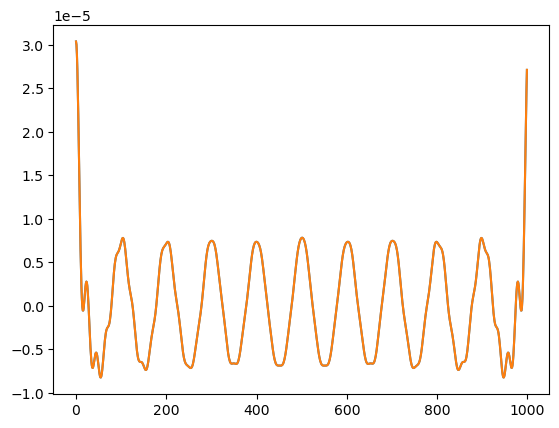

In [282]:
Gamma_k.real.squeeze()
plt.plot(Sigma_x[0,:])
plt.plot(Sigma_lambda[0,:])

In [253]:
k = 0
Gamma_true = data_load['latent']['Gamma'][:50,k,k].real

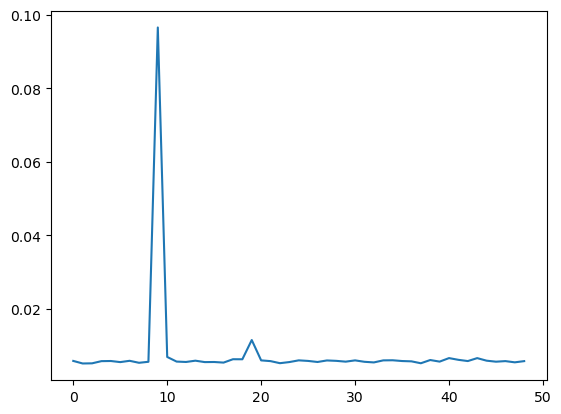

In [255]:
alpha0 = True
test = S_loglink(Gamma_est, Wv, alpha, alpha0)

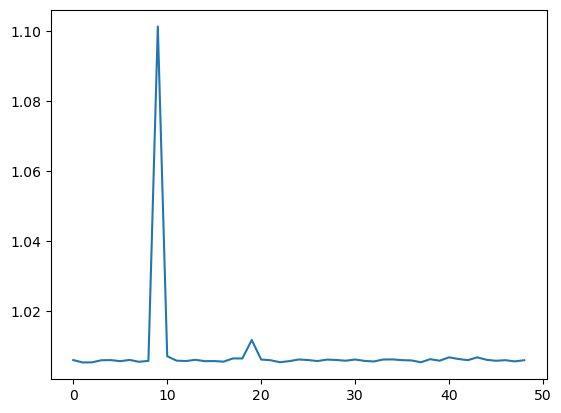

In [267]:
np.exp(Gamma_est[:50,k,k].real*(delta**2*(2*np.pi)**2))

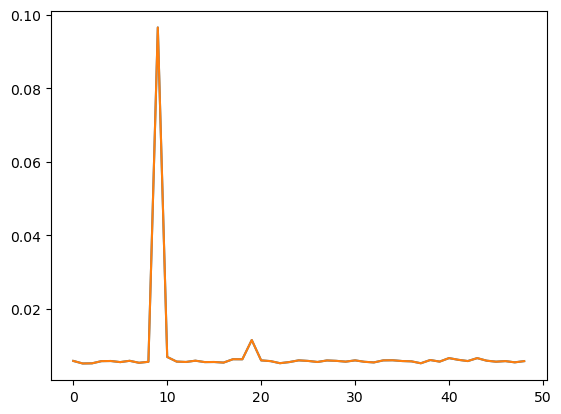

In [263]:
plt.plot(Gamma_est[:50,k,k].real*(delta**2*(2*np.pi)**2))
plt.plot(test[0,:])

In [264]:
np.exp(0.01)

1.010050167084168

In [16]:
model_load.keys()

dict_keys(['Gamma', 'lams', 'tapers', 'Wv', 'track', 'inv_init'])

In [6]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
def get_alpha_data(alpha, link, init_type, optim_type, track=None, alpha0=False):
    fs = 1000
    delta = 1/fs
    seed = 8

    win=1000
    L=50
    C=1
    emiter=25
    K=2

    alpha=float(alpha)

    sample_length = win
    em_iters = emiter

    data_path = f'saved/synthetic_data/simple_synthetic_{link}poisson_fixed_gamma_{K}_{L}_{sample_length}'
    data_load = pickle_open(data_path)
    latent = data_load['latent']
    Gamma = latent['Gamma']
    Wv_data = data_load['meta']['Wv']
    zs = latent['zs']
    xs = latent['xs']


    # obs = data_load['observed']
    alphas = np.array([alpha for k in range(K)])
    lams = cif_alpha_loglink(alphas, xs)
    spikes = sample_spikes_from_xs(lams, C, delta=1/fs, obs_model='poisson')
    Gamma_zest = Gamma_est_from_zs(zs)



    spikes_mc = spikes.mean(1)
    # ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[0,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    model_path = f'saved/fitted_models/simple_synthetic_{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
    # if link == "relu":
    #     model_path = f'saved/fitted_models/simple_synthetic_deltarelupoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'
    # elif link == 'id':
    # else:
    #     raise ValueError

    model_load = pickle_open(model_path)
    Wv_model = model_load['Wv']

    num_J_vars = int(model_load['Gamma'].shape[0]*2)
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)

    S_true = Gamma[:50,0,0].real*(delta**2*(2*np.pi)**2)
    S_true_lambdas = S_loglink(Gamma, Wv_data, alpha, alpha0)
    S_true_lambda = S_true_lambdas[0,:]

    S_oracle = Gamma_zest[:50,0,0].real*(delta**2*(2*np.pi)**2)
    S_oracle_lambdas = S_loglink(Gamma_zest, Wv_data, alpha, alpha0)
    S_oracle_lambda = S_oracle_lambdas[0,:]

    print('S_init')
    S_init = Gamma_init[:50,0,0].real*(delta**2*(2*np.pi)**2)
    S_init_lambdas = S_loglink(Gamma_init, Wv_model, alpha, alpha0)
    S_init_lambda = S_init_lambdas[0,:]
    # S_init = None
    # S_init_lambdas = None
    # S_init_lambda = None

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[:50]
    coh_true = thr_coherence(Gamma[:50,:,:])
    coh_oracle = thr_coherence(Gamma_zest[:50,:,:])
    coh_init = thr_coherence(Gamma_init[:50,:,:])



    print('S_model')
    if track is not None:
        S_model = []
        S_model_lambda = []
        coh_model = []

        for e in range(track[0], track[1]):
            if e % 5 == 0:
                print(f'iter {e}')
            Gamma_est_itr = model_load['track'][0][e]['gamma']
            S_model_itr = Gamma_est_itr[:50,0,0].real*(delta**2*(2*np.pi)**2)
            S_model_itr_lambdas = S_loglink(Gamma_est_itr, Wv_model, alpha, alpha0)
            S_model_itr_lambda = S_model_itr_lambdas[0,:]
            coh_model_itr = thr_coherence(Gamma_est_itr[:50,:,:])

            S_model.append(S_model_itr)
            S_model_lambda.append(S_model_itr_lambda)
            coh_model.append(coh_model_itr)

    else:
        Gamma_est = model_load['Gamma']
        S_model = Gamma_est[:50,0,0].real*(delta**2*(2*np.pi)**2)
        S_model_lambdas = S_loglink(Gamma_est, Wv_model, alpha, alpha0)
        S_model_lambda = S_model_lambdas[0,:]
        coh_model = thr_coherence(Gamma_est[:50,:,:])
    


    S_dict = dict(true=S_true, oracle=S_oracle, model=S_model, naive=S_naive, init=S_init)
    coh_dict = dict(true=coh_true, oracle=coh_oracle, model=coh_model, naive=coh_naive, init=coh_init)
    S_lambda_dict = dict(true=S_true_lambda, oracle=S_oracle_lambda, model=S_model_lambda, naive=S_naive, init=S_init_lambda)

    return dict(coh=coh_dict, S=S_dict, S_lambda=S_lambda_dict, spikes=spikes, lams=lams)



In [7]:
def plot_S(alpha_dict, S_type, ax, logS=False, show_naive=True):
    if S_type == 'lambda':
        S_dict = alpha_dict['S_lambda']
    elif S_type == 'x':
        S_dict = alpha_dict['S']
    else:
        raise ValueError

    S_true = S_dict['true'][:50]
    S_oracle = S_dict['oracle'][:50]
    S_init = S_dict['init'][:50]
    S_naive = S_dict['naive'][:50]

    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)

    # coh_true = alpha_dict['coh']['true']
    # coh_oracle = alpha_dict['coh']['oracle']
    # coh_model = alpha_dict['coh']['model']
    # coh_naive = alpha_dict['coh']['naive']

    ax.plot(S_true, color='k', label='true', linewidth=3)
    ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
    ax.plot(S_oracle, color='tab:green', label='direct')
    if show_naive is True:
        ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


    if track is None:
        S_model = S_dict['model']
        if logS is True:
            S_model = 10*np.log10(S_model)
        ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
        ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
    else:
        S_model_list = S_dict['model']
        S_model_list = S_model_list[:track_show]
        color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
        for e, c in enumerate(color): 
            S_model_itr = S_model_list[e]
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)
            ax.plot(S_model_itr, color=c, linewidth=3, alpha=0.8)
        ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

    if logS is True:
        ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
    else:
        ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
    ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # if k == 3:
        # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
        # ax[i1,i2].set_ylim([low, 1])
    # ax.set_ylim([1e4,1e8])

In [8]:
link = "log"
init_type = "flat"
optim_type = "BFGS"

track = np.array([0,25])
track += 0
# track=None

# alphas = [5.3, 5.7, 6.0, 6.2, 6.4,]
alphas = [6.0]
alpha_fits = []
for alpha in alphas:
    print(alpha)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, track=track, alpha0=False)
    alpha_fits.append(alpha_dict)


6.0
S_init
S_model
iter 0
iter 5
iter 10
iter 15
iter 20


In [ ]:
fig, ax = plt.subplots(1,5,figsize=(18,3))
for a, alpha in enumerate(alphas):
    alpha_dict = alpha_fits[a]
    plot_S(alpha_dict, 'x', ax[a], True, show_naive=False)
    ax[a].set_ylim([-65,-5])

In [ ]:

link = "log"
init_type = "flat"
optim_type = "BFGS"

track = np.array([0,25])
track += 0
# track=None

alphas = [5.3, 5.7, 6.0, 6.2, 6.4,]
alpha_fits = []
for alpha in alphas:
    print(alpha)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, track=track, alpha0=False)
    alpha_fits.append(alpha_dict)





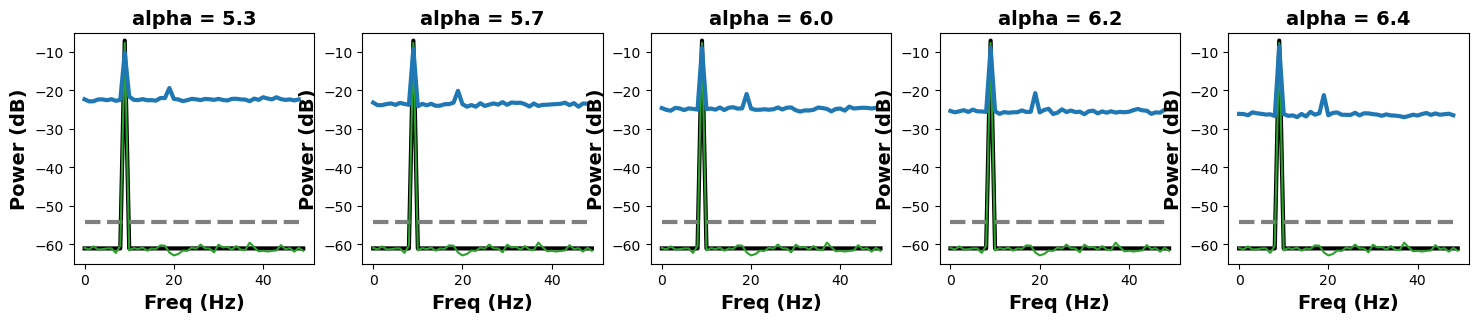

In [192]:
fig, ax = plt.subplots(1,5,figsize=(18,3))
for a, alpha in enumerate(alphas):
    alpha_dict = alpha_fits[a]
    plot_S(alpha_dict, 'x', ax[a], True, show_naive=False)
    ax[a].set_ylim([-65,-5])

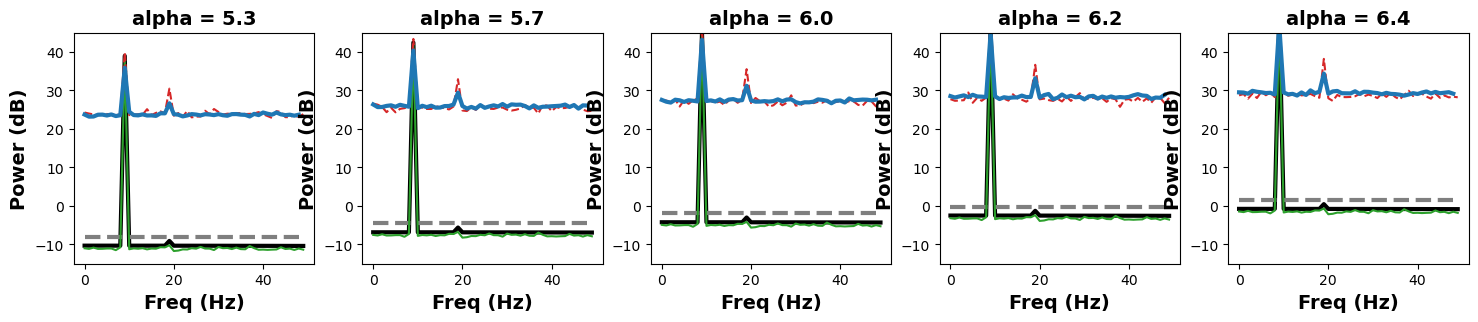

In [193]:
fig, ax = plt.subplots(1,5,figsize=(18,3))
for a, alpha in enumerate(alphas):
    alpha_dict = alpha_fits[a]
    plot_S(alpha_dict, 'lambda', ax[a], True, show_naive=True)
    ax[a].set_ylim([-15,45])


In [194]:
link = "log"
init_type = "flat"
optim_type = "BFGS"

track = np.array([0,25])
track += 0
track=None

alphas = [5.3, 5.7, 6.0, 6.2, 6.4,]
# alphas = [5.3]
alpha_fits = []
for alpha in alphas:
    print(alpha)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, track=track, alpha0=True)
    alpha_fits.append(alpha_dict)





5.3
S_init
S_model
5.7
S_init
S_model
6.0
S_init
S_model
6.2
S_init
S_model
6.4
S_init
S_model


In [230]:
alpha_dict['S']['model'] / alpha_dict['S_lambda']['model'][:50]

array([0.99996469, 0.99996459, 0.99996347, 0.99996634, 0.99996455,
       0.99996455, 0.99996334, 0.99996427, 0.99996204, 0.9999792 ,
       0.99996476, 0.99996227, 0.99996302, 0.99996108, 0.99996462,
       0.99996244, 0.99996623, 0.99996465, 0.99996573, 0.99992543,
       0.9999637 , 0.9999665 , 0.99996712, 0.99996536, 0.99996467,
       0.99996556, 0.99996608, 0.99996515, 0.99996622, 0.99995519,
       0.99996627, 0.9999647 , 0.99996306, 0.9999659 , 0.99996455,
       0.99996491, 0.99996342, 0.99996332, 0.99996421, 0.99997055,
       0.99997065, 0.99997156, 0.99997245, 0.99997118, 0.99997227,
       0.99997179, 0.99997219, 0.99997278, 0.9999718 ])

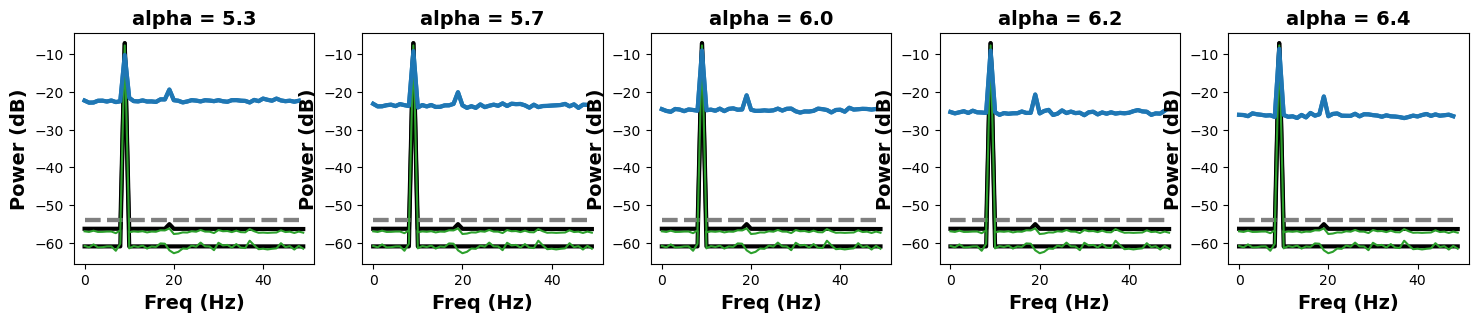

In [226]:
fig, ax = plt.subplots(1,5,figsize=(18,3))
for a, alpha in enumerate(alphas):
    alpha_dict = alpha_fits[a]
    plot_S(alpha_dict, 'x', ax[a], True, show_naive=False)
    plot_S(alpha_dict, 'lambda', ax[a], True, show_naive=False)
    # ax[a].set_ylim([-65,-5])
    # ax[a].set_ylim([0,0.05])

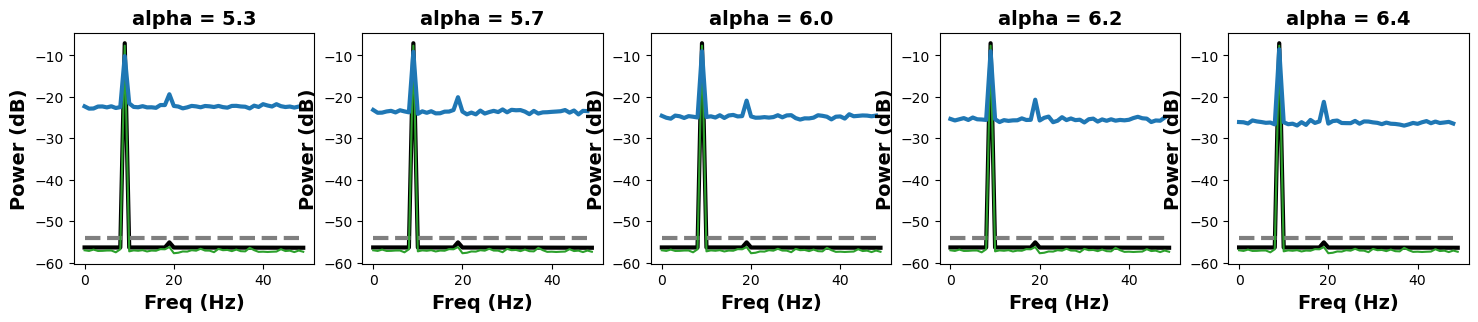

In [225]:
fig, ax = plt.subplots(1,5,figsize=(18,3))
for a, alpha in enumerate(alphas):
    alpha_dict = alpha_fits[a]
    plot_S(alpha_dict, 'lambda', ax[a], True, show_naive=False)
    # ax[a].set_ylim([-15,45])
    # ax[a].set_ylim([0,100000])
    # ax[a].set_ylim([0,0.03])



In [ ]:
# work this out with ReLU...

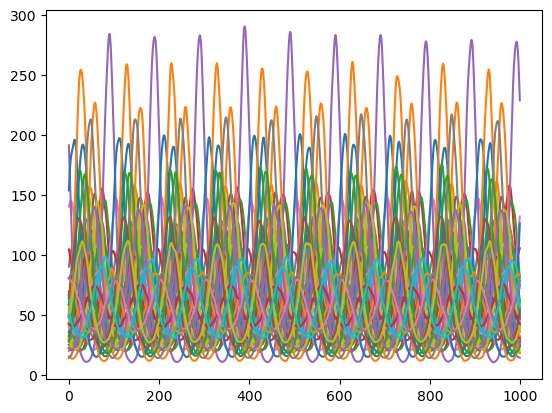

In [75]:
lams = alpha_dict['lams']
spikes = alpha_dict['spikes']
for l in range(L):
    plt.plot(lams[l,0,:])

In [79]:
spikes[:,:,0,:].mean()

0.065

In [51]:
alpha_dict.keys()

dict_keys(['coh', 'S', 'S_lambda'])